<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/Pronti-Beam/demos-experiments/blob/master/notebooks/modnet/modnet_demo_benchmark_edition.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/Pronti-Beam/blob/master/demos-experiments/notebooks/modnet/modnet_demo_benchmark_edition.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td><td>
  <a target="_blank"  href="https://www.linkedin.com/company/pronti-ai/?originalSubdomain=ca">
    <img width=128px src="https://miro.medium.com/max/3402/1*gPSJe7WqcC61cGyB0lxalQ.png" /></a>
</td><td>
  <a target="_blank"  href="http://beamdata.ca/">
    <img width=128px src="http://beamdata.ca/wp-content/uploads/2018/10/beamdata_web_logo.png" /></a>
</td></table>


# MODNet benchmark demo
**Note** Use Runtime: CPU as base of the benchmard

  - pytorch inference:
    - inference cost for batch_size 1: 478.1471ms
  - ONNX Runtime Inference:
    - inference cost for batch_size 1: 359.8167 ms

**Note** Use Runtime: GPU as TensorRT optimize

  - modnet-cpu-simplified.onnx inference:
    - Latency: min = 7.54675 ms, max = 8.21542 ms, mean = 7.71543 ms, median = 7.70303 ms, percentile(99%) = 7.98169 ms
    - GPU Compute Time: min = 7.14722 ms, max = 7.77158 ms, mean = 7.26397 ms, median = 7.25128 ms, percentile(99%) = 7.53656 ms
  - modnet-gpu-simplified.onnx inference:
    - Latency: min = 7.58453 ms, max = 8.2428 ms, mean = 7.76476 ms, median = 7.75586 ms, percentile(99%) = 8.04858 ms
    - GPU Compute Time: min = 7.19623 ms, max = 7.84821 ms, mean = 7.32274 ms, median = 7.30762 ms, percentile(99%) = 7.57153 ms

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<p align="justify">Clone the repository, and download the pre-trained model:</p>

### Pronti MODNet demo

In [ ]:
%cd /content
!ls /content/drive/MyDrive/Cropper
!cp /content/drive/MyDrive/Cropper/cropper_validation.zip /content
!unzip cropper_validation.zip

In [3]:
%cd /content/valid_validation
!mkdir test_run
!cp -r image test_run

/content/valid_validation


In [4]:
%cd /content
!git clone https://github.com/ZHKKKe/MODNet.git

/content
Cloning into 'MODNet'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 234 (delta 11), reused 15 (delta 5), pack-reused 206
Receiving objects: 100% (234/234), 60.76 MiB | 19.50 MiB/s, done.
Resolving deltas: 100% (72/72), done.


#### Download the pre-trained MODNet model

In [5]:
import os
%cd /content/MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

/content/MODNet
Downloading...
From: https://drive.google.com/uc?id=1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz
To: /content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt
26.3MB [00:00, 63.3MB/s]


In [6]:
import os
import glob
!mkdir -p /content/MODNet/test_data/test_human_images
base = '/content/MODNet/test_data/test_human_images'
img_path = '/content/valid_validation/test_run/image'
 
files = glob.glob(f'{base}/*')
 
for f in files:
    os.remove(f)
 
!cp {img_path}/* {base}

In [7]:
!mkdir -p /content/MODNet/test_data/test_human_images_results/
%ls /content/MODNet/test_data/

test_human_images/  test_human_images_results/


#### alpha matte predition

MODNet **inference** using pre-trained .ckpt

In [ ]:
import os
import sys
import argparse
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from src.models.modnet import MODNet

# check input arguments
input_path = '/content/MODNet/test_data/test_human_images'
output_path = '/content/MODNet/test_data/test_human_images_results'
ckpt_path = '/content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(input_path):
  print('Cannot find input path: {0}'.format(input_path))
  exit()
if not os.path.exists(output_path):
  print('Cannot find output path: {0}'.format(output_path))
  exit()
if not os.path.exists(ckpt_path):
  print('Cannot find ckpt path: {0}'.format(ckpt_path))
  exit()

# define hyper-parameters
ref_size = 512

# define image to tensor transform
im_transform = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

# create MODNet and load the pre-trained ckpt
modnet = MODNet(backbone_pretrained=False)
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('using GPU!')
  modnet = nn.DataParallel(modnet).cuda()
else:
  device = torch.device('cpu')
  modnet = nn.DataParallel(modnet)
  print('using CPU!')

modnet.load_state_dict(torch.load(ckpt_path, map_location=device))
modnet.eval() # turn the model to inference model

# inference images
im_names = os.listdir(input_path)
for im_name in im_names:
  print('Process image: {0}'.format(im_name))

  # read image
  im = Image.open(os.path.join(input_path, im_name))

  # unify image channels to 3
  im = np.asarray(im)
  if len(im.shape) == 2:
      im = im[:, :, None]
  if im.shape[2] == 1:
      im = np.repeat(im, 3, axis=2)
  elif im.shape[2] == 4:
      im = im[:, :, 0:3]

  # convert image to PyTorch tensor
  im = Image.fromarray(im)
  im = im_transform(im)

  # add mini-batch dim
  im = im[None, :, :, :]

  # resize image for input
  im_b, im_c, im_h, im_w = im.shape
  if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
      if im_w >= im_h:
          im_rh = ref_size
          im_rw = int(im_w / im_h * ref_size)
      elif im_w < im_h:
          im_rw = ref_size
          im_rh = int(im_h / im_w * ref_size)
  else:
      im_rh = im_h
      im_rw = im_w
  
  im_rw = im_rw - im_rw % 32
  im_rh = im_rh - im_rh % 32
  im = F.interpolate(im, size=(im_rh, im_rw), mode='area')

  # inference
  if torch.cuda.is_available():
    _, _, matte = modnet(im.cuda(), True)
  else:
    _, _, matte = modnet(im, True)

  # resize and save matte
  matte = F.interpolate(matte, size=(im_h, im_w), mode='area')
  matte = matte[0][0].data.cpu().numpy()
  matte_name = im_name.split('.')[0] + '.png'
  Image.fromarray(((matte * 255).astype('uint8')), mode='L').save(os.path.join(output_path, matte_name))


Now simply go ahead and choose a resultant predicton from the dropdown below, the observation widget will recognise a change and toggle a concetanated ground-truth/predicted matte visualization.

In [9]:
from IPython.display import display,  clear_output
from ipywidgets import Dropdown, Output
 
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
 
images = glob.glob('test_data/test_human_images_results/*')
out = Output()
 
def viz(img, save_path=None, resize=0.5):
  imgo = glob.glob(f'{img_path}/{os.path.basename(os.path.splitext(img)[0])}*')
  img = cv2.imread(img)
  org_img = cv2.imread(imgo[0])

  vis_concat = np.concatenate((img, org_img), axis=1)
  result = cv2.resize(vis_concat, (0,0), fx=resize, fy=resize) 
  
  if save_path is not None:
    cv2.imwrite(f'{save_path}/{os.path.basename(imgo[0])}', result)
  else:
    cv2_imshow(result)
 
 
def dropdown_eventhandler(change):
    with out:
        clear_output()
        print('loading...')

        viz(change.new, resize=0.75)
 
dropdown = Dropdown(description="Choose one:", options=images)
dropdown.observe(dropdown_eventhandler, names='value')
display(dropdown)
display(out)

Dropdown(description='Choose one:', options=('test_data/test_human_images_results/004537.png', 'test_data/test…

Output()

### Concatenate result and save to Mydrive

In [15]:
from tqdm.notebook import tqdm
!mkdir -p test_data/test_human_images_results_concat
save_path = 'test_data/test_human_images_results_concat'

for i in tqdm(images):
  viz(i, save_path, resize=1.0)

!cp -r test_data/test_human_images_results_concat /content/drive/MyDrive/Beamdata-Pronti/test_human_images_results_concat-modnet

# Training

While it's not immediately clear that fine-tuning MODNet is a possibility without overfitting it's perfectly possible that combining any labelled images of clothing available with either the `DUTS-TR` geheral object saliency dataset of the `supervisely human dataset` would yield a model that generalises to both domains given the results above 


In [ ]:
!mkdir -p train_data/DUTS/DUTS-TR
%cd train_data/DUTS/DUTS-TR
!wget http://saliencydetection.net/duts/download/DUTS-TR.zip
!unzip DUTS-TR.zip && rm DUTS-TR.zip

# Generate .onnx
- Optimisation

ValueError: Unsupported ONNX opset version: 13

  - opset_version=12



The next step should we decide to continue and pursuse this avenue would be to investigate whether or need this particular graph is rejected by TesnorRT's onnnx parser, or alternatively coreml etc should you want to deploy directly on the edge.

#### install the requirements for converting MODNet to .onnx

In [14]:
%cd /content/MODNet
!pip install -r onnx/requirements.txt

/content/MODNet


### Export to cpu-based .onnx

In [16]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable

from onnx import modnet_onnx

ckpt_path = '/content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'
# check input arguments
if not os.path.exists(ckpt_path):
    print('Cannot find checkpoint path: {0}'.format(ckpt_path))
    exit()

# define model & load checkpoint
modnet = modnet_onnx.MODNet(backbone_pretrained=False)

# prepare dummy_input
batch_size = 1
height = 512
width = 512

# dummy_input: input tensor x. The values in this can be random as long as it is the right type and size
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('using gpu!')
  dummy_input = Variable(torch.randn(batch_size, 3, height, width)).cuda()
  modnet = nn.DataParallel(modnet).cuda()

else:
  device = torch.device('cpu')
  print('using cpu')
  dummy_input = Variable(torch.randn(batch_size, 3, height, width))
  modnet = nn.DataParallel(modnet)

state_dict = torch.load(ckpt_path, map_location=device)
modnet.load_state_dict(state_dict)
modnet.eval() # set the model to inference mode

# general input
input_name = '/content/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'
if torch.cuda.is_available():
  output_name = '/content/MODNet/pretrained/modnet-gpu.onnx'
else:
  output_name = '/content/MODNet/pretrained/modnet-cpu.onnx'


# export to onnx model
torch.onnx.export(
    modnet.module, dummy_input, output_name, export_params = True, 
    input_names = ['input'], output_names = ['output'], 
    dynamic_axes = {'input': {0:'batch_size', 2:'height', 3:'width'}, 'output': {0: 'batch_size', 2: 'height', 3: 'width'}}, opset_version=12)

%ls /content/MODNet/pretrained/

using cpu


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


modnet-cpu.onnx  modnet_photographic_portrait_matting.ckpt  README.md


.onnx is a binary protobuf file which contains both the network structure and parameters of the model

Save modnet-cpu.onnx to drive for further onnx simplifier later

In [18]:
!cp /content/MODNet/pretrained/modnet-cpu.onnx /content/drive/MyDrive/Beamdata-Pronti/models/

### Output of PyTorch and ONNX match test
  - trace-based means that it operates by executing your model once
  - the output of PyTorch and ONNX Runtime runs match numerically with the given precision (rtol=1e-03 and atol=1e-05)
  - onnx exporter is correct

In [19]:
import onnxruntime
import numpy as np


# Input to the model
x = torch.randn(1, 3, 512, 512, requires_grad=True)
torch_out = modnet(x)

ort_session = onnxruntime.InferenceSession("/content/MODNet/pretrained/modnet-cpu.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Exported model has been tested with ONNXRuntime, and the result looks good!


#ONNX Runtime

Just as we've seen with ESNet I'm providing data with a dataloader except here we're using the custom data loader provided, along transforms shown in the U-2-Net repo including rescaling to 320x320

In [20]:
!pip install onnxruntime
!pip install onnx

In [26]:
import glob
import os

%cd /content/MODNet/
img_name_list = glob.glob('/content/valid_validation/test_run/image/' + os.sep + '*')

/content/MODNet


In [27]:
import torchvision
from torchvision import transforms

val_data = "/content/valid_validation/test_run"

TRANSFORM_IMG = transforms.Compose([
     transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

val = torchvision.datasets.ImageFolder(val_data, transform=TRANSFORM_IMG)

In [24]:
# ONNX Runtime Inference

from torch.utils.data import Dataset, DataLoader

import onnxruntime as rt  
import time
from tqdm.notebook import tqdm

n_runs = 200

sess_options = rt.SessionOptions()

sess_options.intra_op_num_threads = 4
sess_options.execution_mode = rt.ExecutionMode.ORT_SEQUENTIAL
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_ALL

# To enable model serialization and store the optimized graph to desired location.
#sess_options.optimized_model_filepath = '/content/esnet/optimized/esnet.onnx'
session = rt.InferenceSession('/content/MODNet/pretrained/modnet-cpu.onnx', sess_options=sess_options)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

dynamic = False
if dynamic:
  bsize = (1,2,4,8,16,32,64)
else:
  bsize = (1,)

start_full = time.time()
for batch_size in bsize:
    runtimes = []
    for _ in tqdm(range(n_runs)):
        dataloader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers=4)
        batch = next(iter(dataloader))
        batch = tuple(t.to('cpu') for t in batch)

        start = time.time()
        pred = session.run([output_name], {input_name: batch[0].numpy()})[0]
        end = time.time()
        runtimes.append((end-start)*1000)

        #print(pred.shapredictions, bitmask = torch.max(pred_torch, 1)pe)
    print(f"inference cost for batch_size {batch_size}: {round(sum(runtimes)/len(runtimes), 4)} ms")

end_full = time.time()
overall_cost = (end_full - start_full)
print(f"overall inference execution cost: {round(overall_cost, 4)} seconds")


inference cost for batch_size 1: 355.1602 ms
overall inference execution cost: 102.174 seconds


### dynamic = True, 
  - batch_size test

In [8]:
# ONNX Runtime Inference

from torch.utils.data import Dataset, DataLoader

import onnxruntime as rt  
import time
from tqdm.notebook import tqdm

n_runs = 200

sess_options = rt.SessionOptions()

sess_options.intra_op_num_threads = 4
sess_options.execution_mode = rt.ExecutionMode.ORT_SEQUENTIAL
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_ALL

# To enable model serialization and store the optimized graph to desired location.
#sess_options.optimized_model_filepath = '/content/esnet/optimized/esnet.onnx'
session = rt.InferenceSession('/content/MODNet/pretrained/modnet-cpu.onnx', sess_options=sess_options)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

dynamic = True
if dynamic:
  bsize = (1,2,4,8,16,32,64)
else:
  bsize = (1,)

start_full = time.time()
for batch_size in bsize:
    runtimes = []
    for _ in tqdm(range(n_runs)):
        dataloader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers=4)
        batch = next(iter(dataloader))
        batch = tuple(t.to('cpu') for t in batch)

        start = time.time()
        pred = session.run([output_name], {input_name: batch[0].numpy()})[0]
        end = time.time()
        runtimes.append((end-start)*1000)

        #print(pred.shapredictions, bitmask = torch.max(pred_torch, 1)pe)
    print(f"inference cost for batch_size {batch_size}: {round(sum(runtimes)/len(runtimes), 4)} ms")

end_full = time.time()
overall_cost = (end_full - start_full)
print(f"overall inference execution cost: {round(overall_cost, 4)} seconds")


inference cost for batch_size 1: 539.3214 ms



inference cost for batch_size 2: 1119.0548 ms



inference cost for batch_size 4: 1967.1371 ms



inference cost for batch_size 8: 3915.729 ms


KeyboardInterrupt: ignored

#### modnet-cpu.onnx
  - inference cost for batch_size 1: 539.3214 ms
  - inference cost for batch_size 2: 1119.0548 ms
  - inference cost for batch_size 4: 1967.1371 ms
  - inference cost for batch_size 8: 3915.729 ms


#Pytorch comparison




In [25]:
import time
from tqdm.notebook import tqdm

dynamic = False


if dynamic:
  bsize = (1,2,4,8,16,32,64)
else:
  bsize = (1,)

n_runs = 200

start_full = time.time()
for batch_size in bsize:
    runtimes = []
    for _ in tqdm(range(n_runs)):
        dataloader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers=4)
        batch = next(iter(dataloader))
        # batch = batch['image'].type(torch.FloatTensor)
        batch = tuple(t.to('cpu') for t in batch)
        # input = Variable(batch)

        #print(batch)
        start = time.time()
        # d1,d2,d3,d4,d5,d6,d7= net(input)
        d1 = modnet(batch[0])
        end = time.time()
        runtimes.append((end-start)*1000)

        #print(pred.shape)
    print(f"inference cost for batch_size {batch_size}: {round(sum(runtimes)/len(runtimes), 4)}ms")

end_full = time.time()
overall_cost = (end_full - start_full)
print(f"overall inference execution cost: {round(overall_cost, 4)} seconds")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  



inference cost for batch_size 1: 477.109ms
overall inference execution cost: 137.8572 seconds


### dynamic = True, 
  - batch_size test

In [9]:
import time
from tqdm.notebook import tqdm

dynamic = True


if dynamic:
  bsize = (1,2,4,8,16,32,64)
else:
  bsize = (1,)

n_runs = 200

start_full = time.time()
for batch_size in bsize:
    runtimes = []
    for _ in tqdm(range(n_runs)):
        dataloader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers=4)
        batch = next(iter(dataloader))
        # batch = batch['image'].type(torch.FloatTensor)
        batch = tuple(t.to('cpu') for t in batch)
        # input = Variable(batch)

        #print(batch)
        start = time.time()
        # d1,d2,d3,d4,d5,d6,d7= net(input)
        d1 = modnet(batch[0])
        end = time.time()
        runtimes.append((end-start)*1000)

        #print(pred.shape)
    print(f"inference cost for batch_size {batch_size}: {round(sum(runtimes)/len(runtimes), 4)}ms")

end_full = time.time()
overall_cost = (end_full - start_full)
print(f"overall inference execution cost: {round(overall_cost, 4)} seconds")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "



inference cost for batch_size 1: 655.4115ms



inference cost for batch_size 2: 1326.4062ms



inference cost for batch_size 4: 2622.8371ms



inference cost for batch_size 8: 5196.7031ms


KeyboardInterrupt: ignored

#### modnet-cpu.onnx
  - inference cost for batch_size 1: 655.4115ms
  - inference cost for batch_size 2: 1326.4062ms
  - inference cost for batch_size 4: 2622.8371ms
  - inference cost for batch_size 8: 5196.7031ms


### Using of data_loader.py

In [28]:
!cp /content/drive/MyDrive/script/data_loader.py .

In [29]:
import torchvision
from torchvision import transforms
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from tqdm.notebook import tqdm
 
 
test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(512),
                                                                      ToTensorLab(flag=0)]))

#### Pytorch inference

In [31]:
import time
from tqdm.notebook import tqdm


if dynamic:
  bsize = (1,2,4,8,16,32,64)
else:
  bsize = (1,)

n_runs = 100
dynamic = False

test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                        num_workers=1)

start_full = time.time()
for batch_size in bsize:
    runtimes = []
    for _ in tqdm(range(n_runs)):
        batch = next(iter(test_salobj_dataloader))
        batch = batch['image'].type(torch.FloatTensor)
        input = Variable(batch)

        #print(batch)
        start = time.time()
        d1 = modnet(input)
        end = time.time()
        runtimes.append((end-start)*1000)

        #print(pred.shape)
    print(f"inference cost for batch_size {batch_size}: {round(sum(runtimes)/len(runtimes), 4)}ms")

end_full = time.time()
overall_cost = (end_full - start_full)
print(f"overall inference execution cost: {round(overall_cost, 4)} seconds")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  



inference cost for batch_size 1: 478.1471ms
overall inference execution cost: 81.467 seconds


#### ONNX Runtime Inference


In [32]:
 from torch.utils.data import Dataset, DataLoader
 
import onnxruntime as rt  
import time
import numpy as np
from tqdm.notebook import tqdm
 
n_runs = 100
 
sess_options = rt.SessionOptions()
 
sess_options.intra_op_num_threads = 4
sess_options.execution_mode = rt.ExecutionMode.ORT_SEQUENTIAL
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_ALL
 
# To enable model serialization and store the optimized graph to desired location.
#sess_options.optimized_model_filepath = '/content/esnet/optimized/esnet.onnx'
session = rt.InferenceSession('/content/MODNet/pretrained/modnet-cpu.onnx', sess_options=sess_options)
 
input_name = session.get_inputs()[0].name
print(input_name) 
 
if dynamic:
  bsize = (1,2,4,8,16,32,64)
else:
  bsize = (1,)
 
test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                        num_workers=1)
start_full = time.time()
for batch_size in bsize:
    runtimes = []
    for _ in tqdm(range(n_runs)):
        batch = next(iter(test_salobj_dataloader))
        start = time.time()
        # d1,d2,d3,d4,d5,d6,d7 = session.run(None, {input_name: batch['image'].cpu().numpy().astype(np.float32)})
        d1 = session.run(None, {input_name: batch['image'].cpu().numpy().astype(np.float32)})
        end = time.time()
        runtimes.append((end-start)*1000)
 
    print(f"inference cost for batch_size {batch_size}: {round(sum(runtimes)/len(runtimes), 4)} ms")
 
end_full = time.time()
overall_cost = (end_full - start_full)
print(f"overall inference execution cost: {round(overall_cost, 4)} seconds")

input



inference cost for batch_size 1: 359.8167 ms
overall inference execution cost: 66.4903 seconds


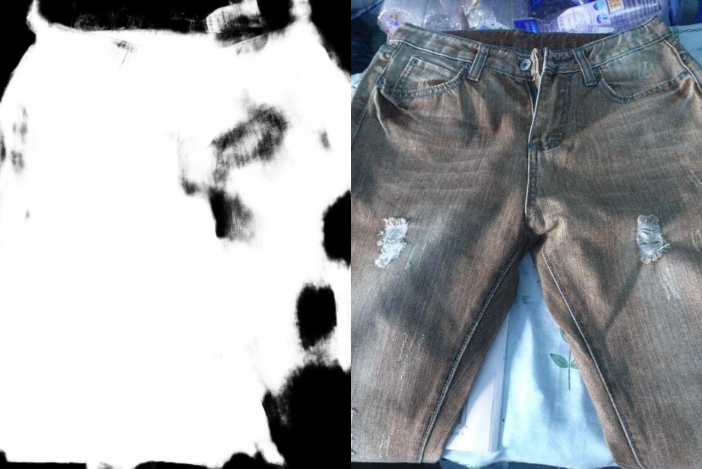

In [34]:
from PIL import Image
from skimage import io, transform
from google.colab.patches import cv2_imshow
import cv2

np.seterr(divide='ignore', invalid='ignore')

def normPRED(d):    
  ma = np.argmax(d, 0)
  mi = np.argmin(d, 0)
  dn = (d-mi)/(ma-mi)
  return dn

pred = d1[0][:,0,:,:]
predict = normPRED(pred)
predict = pred.squeeze()

im = Image.fromarray(predict*255).convert('RGB')
idx = batch['imidx'].numpy()[0][0]
image_name = img_name_list[idx]

 
img_name = image_name.split(os.sep)[-1]
image = io.imread(image_name)
imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)
imo.save('test.png')


IMG = cv2.imread('test.png')
 
vis_concat = np.concatenate((IMG, image), axis=1)
result = cv2.resize(vis_concat, (0,0), fx=0.75, fy=0.75)
 
cv2_imshow(result)

# TensorRT

Alright! We're jst going to head through the same procedure as you've already seen in previous examples here in order to check for future scope, bearing in mind once again that tensorrt would be a persistent installtion should this be utilized in a GPU accelarated instance or local machine.

**Note** - just a quick reminder to switch to a GPU runtime for the following optimization procedure.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#@title Install Tensorrt
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin

!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600

!wget http://developer.download.nvidia.com/compute/cuda/11.0.2/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb

!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!sudo apt-get update
!wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt-get update




!apt-get install -y --no-install-recommends libnvinfer8 libnvinfer-dev  python3-libnvinfer-dev
!pip install pycuda
#libnvinfer8-8.0.0-1.cuda11

--2021-06-22 02:35:18--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu1804.pin’

cuda-ubuntu1804.pin 100%[===================>]     190  --.-KB/s    in 0s      

2021-06-22 02:35:18 (3.22 MB/s) - ‘cuda-ubuntu1804.pin’ saved [190/190]

--2021-06-22 02:35:18--  http://developer.download.nvidia.com/compute/cuda/11.0.2/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:80... connected.
HTTP request sent, awaiting response... 200 OK


In [3]:
%ls /content/

cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
drive/
nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
sample_data/


In [4]:
%cd /content
!cp /content/drive/MyDrive/tools/TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz /content
!tar -xzf /content/TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz

/content


In [5]:
%ls /content/

cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
drive/
nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
sample_data/
TensorRT-8.0.0.3/
TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz


In [ ]:
%cd /content/TensorRT-8.0.0.3
print('Installing necessary Python wheels...')
!pip3 install /content/TensorRT-8.0.0.3/python/tensorrt-8.0.0.3-cp37-none-linux_x86_64.whl
!sudo dpkg -i /content/drive/MyDrive/tools/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423_1-1_amd64.deb
!sudo apt-key add /var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423/7fa2af80.pub
!sudo apt-get update
!sudo apt-get install tensorrt

In [ ]:
#Otherwise we get a random pad node error
!pip3 install -U pip && pip3 install onnx-simplifier

### onnxsim modnet-cpu.onnx

In [17]:
#Note that while the onnx IR is portable, the engine needs to be built on the target device/server hence the copy
!cp /content/drive/MyDrive/Beamdata-Pronti/models/modnet-cpu.onnx /content

In [9]:
!python3 -m onnxsim /content/modnet-cpu.onnx /content/modnet-cpu-simplified.onnx --input-shape 1,3,512,512

Simplifying...
Note: The input shape of the simplified model will be overwritten by the value of '--input-shape' argument. Pass '--dynamic-input-shape' if it is not what you want. Run 'python3 -m onnxsim -h' for details.
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


In [10]:
!/usr/src/tensorrt/bin/trtexec --onnx=/content/modnet-cpu-simplified.onnx --explicitBatch --workspace=2048 --fp16 --saveEngine=/content/modnet.plan

&&&& RUNNING TensorRT.trtexec [TensorRT v8000] # /usr/src/tensorrt/bin/trtexec --onnx=/content/modnet-cpu-simplified.onnx --explicitBatch --workspace=2048 --fp16 --saveEngine=/content/modnet.plan
[06/22/2021-02:43:27] [I] === Model Options ===
[06/22/2021-02:43:27] [I] Format: ONNX
[06/22/2021-02:43:27] [I] Model: /content/modnet-cpu-simplified.onnx
[06/22/2021-02:43:27] [I] Output:
[06/22/2021-02:43:27] [I] === Build Options ===
[06/22/2021-02:43:27] [I] Max batch: explicit
[06/22/2021-02:43:27] [I] Workspace: 2048 MiB
[06/22/2021-02:43:27] [I] minTiming: 1
[06/22/2021-02:43:27] [I] avgTiming: 8
[06/22/2021-02:43:27] [I] Precision: FP32+FP16
[06/22/2021-02:43:27] [I] Calibration: 
[06/22/2021-02:43:27] [I] Refit: Disabled
[06/22/2021-02:43:27] [I] Sparsity: Disabled
[06/22/2021-02:43:27] [I] Safe mode: Disabled
[06/22/2021-02:43:27] [I] Enable serialization: Disabled
[06/22/2021-02:43:27] [I] Save engine: /content/modnet.plan
[06/22/2021-02:43:27] [I] Load engine: 
[06/22/2021-02:43:2

In [13]:
!cp /content/modnet.plan /content/drive/MyDrive/Beamdata-Pronti/models/

### onnxsim modnet-gpu.onnx

In [18]:
!cp /content/drive/MyDrive/Beamdata-Pronti/models/modnet-gpu.onnx /content

In [19]:
!python3 -m onnxsim /content/modnet-gpu.onnx /content/modnet-gpu-simplified.onnx --input-shape 1,3,512,512

Simplifying...
Note: The input shape of the simplified model will be overwritten by the value of '--input-shape' argument. Pass '--dynamic-input-shape' if it is not what you want. Run 'python3 -m onnxsim -h' for details.
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


In [20]:
!/usr/src/tensorrt/bin/trtexec --onnx=/content/modnet-gpu-simplified.onnx --explicitBatch --workspace=2048 --fp16 --saveEngine=/content/modnet-cpu-onnx-simplified.plan

&&&& RUNNING TensorRT.trtexec [TensorRT v8000] # /usr/src/tensorrt/bin/trtexec --onnx=/content/modnet-gpu-simplified.onnx --explicitBatch --workspace=2048 --fp16 --saveEngine=/content/modnet-cpu-onnx-simplified.plan
[06/22/2021-02:57:31] [I] === Model Options ===
[06/22/2021-02:57:31] [I] Format: ONNX
[06/22/2021-02:57:31] [I] Model: /content/modnet-gpu-simplified.onnx
[06/22/2021-02:57:31] [I] Output:
[06/22/2021-02:57:31] [I] === Build Options ===
[06/22/2021-02:57:31] [I] Max batch: explicit
[06/22/2021-02:57:31] [I] Workspace: 2048 MiB
[06/22/2021-02:57:31] [I] minTiming: 1
[06/22/2021-02:57:31] [I] avgTiming: 8
[06/22/2021-02:57:31] [I] Precision: FP32+FP16
[06/22/2021-02:57:31] [I] Calibration: 
[06/22/2021-02:57:31] [I] Refit: Disabled
[06/22/2021-02:57:31] [I] Sparsity: Disabled
[06/22/2021-02:57:31] [I] Safe mode: Disabled
[06/22/2021-02:57:31] [I] Enable serialization: Disabled
[06/22/2021-02:57:31] [I] Save engine: /content/modnet-cpu-onnx-simplified.plan
[06/22/2021-02:57:3

In [21]:
!cp /content/modnet-cpu-onnx-simplified.plan /content/drive/MyDrive/Beamdata-Pronti/models/

# Model Visualization

In [24]:
!pip install -q netron

In [32]:
%ls

cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
drive/
modnet-cpu.onnx
modnet-cpu-onnx-simplified.plan
modnet-cpu-simplified.onnx
modnet-gpu.onnx
modnet-gpu-simplified.onnx
modnet.plan
nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
sample_data/
TensorRT-8.0.0.3/
TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz


## Model Visualization via Netron

### modnet-gpu.onnx

In [37]:
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('modnet-gpu.onnx', address=port, browse=True)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>

### modnet-cpu.onnx

In [33]:
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('modnet-cpu.onnx', address=port, browse=True)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>

modnet-cpu-simplified.onnx

In [35]:
import netron
import portpicker
from google.colab import output

port = portpicker.pick_unused_port()

# Read the model file and start the netron browser.
with output.temporary():
  netron.start('modnet-cpu-simplified.onnx', address=port, browse=True)

output.serve_kernel_port_as_iframe(port, height='800')

<IPython.core.display.Javascript object>